In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

# Read in and process data

Load already processed dataframes from the csv files

In [23]:
# cellpose_file = "cellpose_results/cellpose_run04_240427113411.csv"
cellpose_file = "cellpose_results/cellpose_run04_240501153104.csv"
# food_file = "FoodSeg103_results/food_run04_240428133857.csv"
food_file = "FoodSeg103_results/food_run04_240501155333.csv"
cellpose_df = pd.read_csv(f'{cellpose_file[:-4]}_processed.csv')
cellpose_df = cellpose_df.rename(columns={"prediction type": "prediction tag"})
food_df = pd.read_csv(f'{food_file[:-4]}_processed.csv')
food_df = food_df.rename(columns={"prediction type": "prediction tag"})

for df in [cellpose_df, food_df]:
    # Show shape, the first rows and the mean values for each scribbles bin
    print(df.shape)
    # display(df[:15])
    display(df.groupby('scribbles bin').agg({'perc. labelled': 'mean', 'pix_labelled': 'mean', 'accuracy': 'mean'}))

(60480, 30)


,perc. labelled,pix_labelled,accuracy
scribbles bin,,,
0.010,0.008876,15.894444,0.749858
0.025,0.022330,41.655556,0.808502
0.050,0.045392,84.290741,0.838074
0.100,0.092680,171.809259,0.862656
0.250,0.239392,441.694444,0.884562
0.500,0.485309,893.875926,0.894470
1.000,0.978887,1802.096296,0.901637
10.000,10.102773,18443.907407,0.911592


(19320, 26)


,perc. labelled,pix_labelled,accuracy
scribbles bin,,,
0.25,0.247791,392.450000,0.651148
1.00,0.973125,1573.015217,0.761077
5.00,4.958578,8008.602174,0.869250


Load raw dataframes and process them

In [10]:
# # Load the dataframes from the csv files
# # cellpose_file = "cellpose_results/cellpose_run04_240427113411.csv"
# cellpose_file = "cellpose_results/cellpose_run04_240501153104.csv"
# # food_file = "FoodSeg103_results/food_run04_240428133857.csv"
# food_file = "FoodSeg103_results/food_run04_240501155333.csv"
# cellpose_df = pd.read_csv(cellpose_file)
# food_df = pd.read_csv(food_file)

# For each metric, add a column for the improvement over the ilastik prediction
# for df in [cellpose_df, food_df]:
#     for metric in ['accuracy', 'mIoU', 'mPrecision', 'mRecall', 'mF1']:
#         for scr in df['scribbles'].unique():
#             perf_il = df.loc[(df['scribbles'] == scr) & (df['prediction tag'] == "ilastik"), metric].values[0]
#             df.loc[(df['scribbles'] == scr), f'{metric}_impr_to_ilastik'] = df.loc[(df['scribbles'] == scr), metric] - perf_il

# # Show the dataframes
# for df in [cellpose_df, food_df]:
    
#     # Show shape, the first rows and the mean values for each scribbles bin
#     print(df.shape)
#     # display(df[:15])
#     display(df.groupby('scribbles bin').agg({'perc. labelled': 'mean', 'pix_labelled': 'mean', 'accuracy': 'mean'}))

Save processed dataframes to csv files

In [11]:
# cellpose_df.to_csv(f'{cellpose_file[:-4]}_processed.csv', index=False)
# food_df.to_csv(f'{food_file[:-4]}_processed.csv', index=False)

# Choose performance METRIC and DATASET

In [12]:
metric = "accuracy"
# metric = "mPrecision"
# metric = "mRecall"
# metric = "mIoU"
# metric = "mF1"

In [20]:
# use_for_all = "cellpose"
use_for_all = "food"

# Inspect the dataset

### Check for extreme cases by sorting

Examples: best cases for certain model, or worst performance compared to Ilastik

In [24]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df_filtered[df_filtered['layers'] == 0]
# df_filtered = df_filtered[df_filtered['scalings'] == 1]
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# List the 10 cases where convpaint performs the worst compared to ilastik
df_filtered.sort_values(by=f'{metric}_impr_to_ilastik', ascending=True)[0:10]

,img_num,prediction tag,scribbles mode,scribbles bin,suffix,max_class_pix_gt,min_class_pix_gt,pix_labelled,max_class_pix_labelled,min_class_pix_labelled,...,mF1,scribbles,prediction,accuracy_impr_to_ilastik,mIoU_impr_to_ilastik,mPrecision_impr_to_ilastik,mRecall_impr_to_ilastik,mF1_impr_to_ilastik,layers,scalings
505,128,convpaint_l-0_s-1-2,all,0.25,w3_run04,45896,6288,135,65401,25,...,0.421946,/mnt/imaging.data/rschwob/food_run04/0128_scri...,/mnt/imaging.data/rschwob/food_run04/0128_conv...,-0.242325,-0.174884,-0.209744,-0.051074,-0.174000,0,1-2
1177,304,convpaint_l-0_s-1-2,all,0.25,w3_run04,89073,27249,435,196685,76,...,0.683057,/mnt/imaging.data/rschwob/food_run04/0304_scri...,/mnt/imaging.data/rschwob/food_run04/0304_conv...,-0.206656,-0.279119,-0.176318,-0.178378,-0.211119,0,1-2
3949,1016,convpaint_l-0_s-1-2,all,0.25,w3_run04,118570,19261,414,196194,51,...,0.617510,/mnt/imaging.data/rschwob/food_run04/1016_scri...,/mnt/imaging.data/rschwob/food_run04/1016_conv...,-0.148341,-0.143419,-0.169027,-0.033240,-0.129696,0,1-2
13833,3456,convpaint_l-0_s-1-2,all,1.00,w3_run04,95047,32120,1556,173036,280,...,0.639933,/mnt/imaging.data/rschwob/food_run04/3456_scri...,/mnt/imaging.data/rschwob/food_run04/3456_conv...,-0.143798,-0.296401,-0.158208,-0.233705,-0.247798,0,1-2
8905,2240,convpaint_l-0_s-1-2,all,0.25,w3_run04,150997,8330,429,200321,27,...,0.509847,/mnt/imaging.data/rschwob/food_run04/2240_scri...,/mnt/imaging.data/rschwob/food_run04/2240_conv...,-0.141574,-0.114869,-0.171500,0.033512,-0.100177,0,1-2
15331,3872,convpaint_l-0_s-1-2,all,0.25,w3_run04,146227,4538,434,196686,24,...,0.390054,/mnt/imaging.data/rschwob/food_run04/3872_scri...,/mnt/imaging.data/rschwob/food_run04/3872_conv...,-0.131042,-0.033155,-0.150252,0.138416,-0.028542,0,1-2
7897,1976,convpaint_l-0_s-1-2,all,0.25,w3_run04,25751,15038,117,65419,25,...,0.712488,/mnt/imaging.data/rschwob/food_run04/1976_scri...,/mnt/imaging.data/rschwob/food_run04/1976_conv...,-0.105713,-0.271767,-0.173620,-0.164493,-0.214092,0,1-2
17683,4432,convpaint_l-0_s-1-2,all,0.25,w3_run04,60669,21264,262,111668,56,...,0.594081,/mnt/imaging.data/rschwob/food_run04/4432_scri...,/mnt/imaging.data/rschwob/food_run04/4432_conv...,-0.096962,-0.161936,-0.178335,-0.090947,-0.136687,0,1-2
8541,2136,convpaint_l-0_s-1-2,all,1.00,w3_run04,126777,21164,1721,194887,193,...,0.636373,/mnt/imaging.data/rschwob/food_run04/2136_scri...,/mnt/imaging.data/rschwob/food_run04/2136_conv...,-0.083155,-0.047325,-0.142645,0.069354,-0.054470,0,1-2
2031,544,convpaint_l-0_s-1-2,all,1.00,w3_run04,63880,14132,2060,194548,126,...,0.599955,/mnt/imaging.data/rschwob/food_run04/0544_scri...,/mnt/imaging.data/rschwob/food_run04/0544_conv...,-0.082581,-0.136782,-0.104555,-0.083604,-0.115656,0,1-2


### Check distribution of performance among the dataset

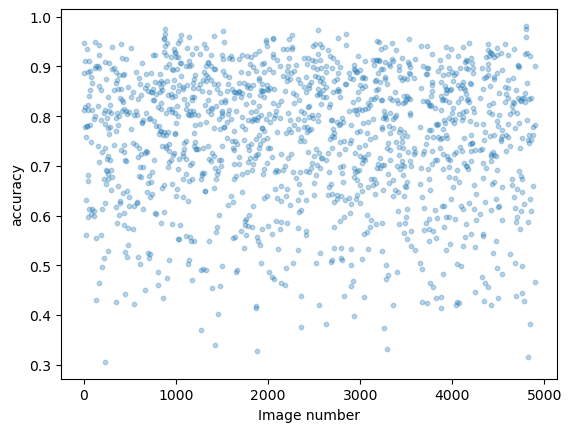

In [25]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# Plot
plt.scatter(df_filtered['img_num'], df_filtered[metric], alpha=0.3, s=10)
plt.xlabel('Image number')
plt.ylabel(metric)
plt.show()

# Check distribution of the _improvements over Ilastik_ among the dataset

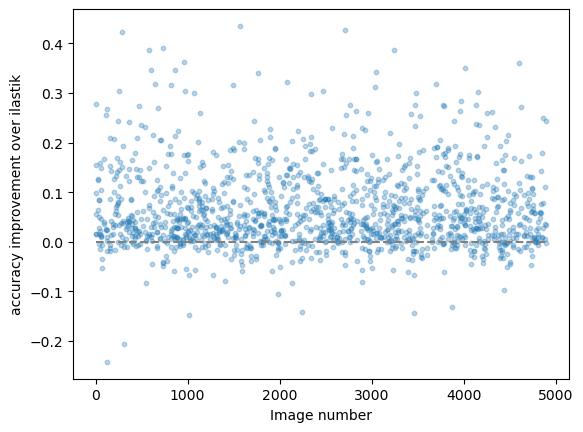

In [26]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# Plot
plt.scatter(x = df_filtered['img_num'], y = df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=10)
plt.xlabel('Image number')
plt.ylabel(f'{metric} improvement over ilastik')
plt.hlines(0, np.min(df_filtered['img_num']), np.max(df_filtered['img_num']), colors='grey', linestyles='dashed')
plt.show()

### Correlation between pixels labelled and improvement

Cellpose: Pixels labelled in one or the other class (not working for FoodSeg103 with multiple classes)

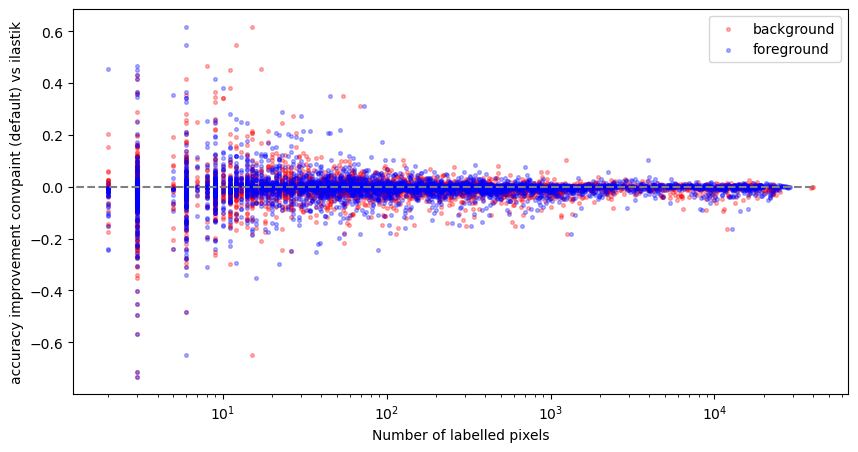

In [27]:
# Define which dataframe to use
df = cellpose_df.copy()

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.scatter(df_filtered["class_1_pix_labelled"], df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=7, c="red", label="background")
plt.scatter(df_filtered["class_2_pix_labelled"], df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=7, c = "blue", label="foreground")
plt.xlabel("Number of labelled pixels")
plt.xscale("log")
plt.hlines(0, 0, np.max([np.max(df_filtered["class_1_pix_labelled"]), np.max(df_filtered["class_1_pix_labelled"])]), colors='grey', linestyles='dashed')
plt.ylabel(f'{metric} improvement convpaint (default) vs ilastik')
plt.legend()
plt.show()

Minimum/maximum pixels labelled among classes

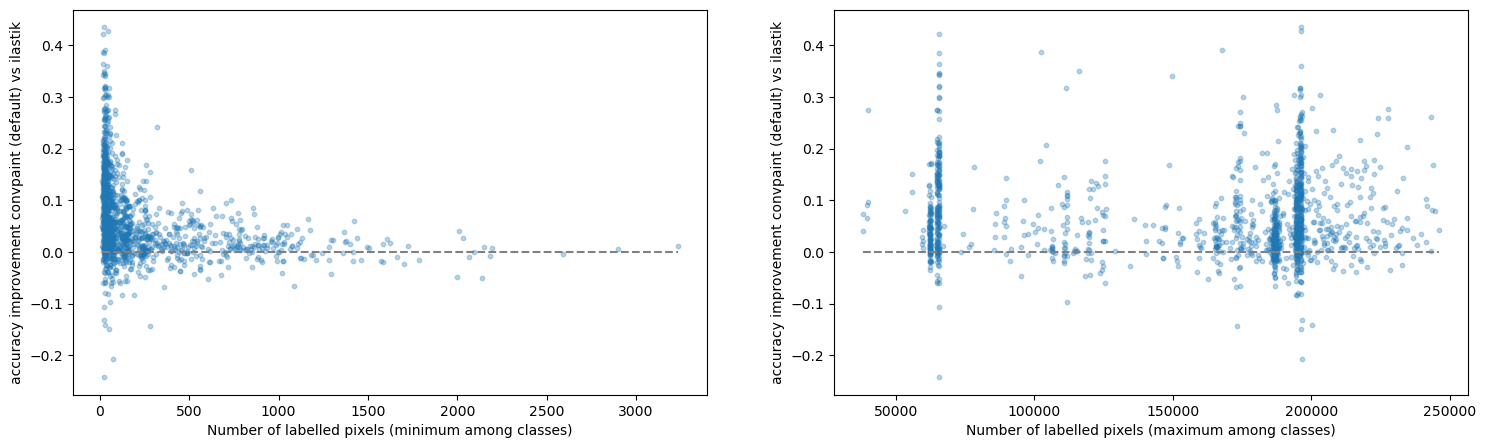

In [28]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
ax1.scatter(x = df_filtered['min_class_pix_labelled'], y = df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=10)
ax1.set_xlabel("Number of labelled pixels (minimum among classes)")
# ax1.set_xscale("log")
ax1.hlines(0, np.min(df_filtered['min_class_pix_labelled']), np.max(df_filtered['min_class_pix_labelled']), colors='grey', linestyles='dashed')
ax1.set_ylabel(f'{metric} improvement convpaint (default) vs ilastik')
ax2.scatter(x = df_filtered['max_class_pix_labelled'], y = df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=10)
ax2.set_xlabel("Number of labelled pixels (maximum among classes)")
# ax2.set_xscale("log")
ax2.hlines(0, np.min(df_filtered['max_class_pix_labelled']), np.max(df_filtered['max_class_pix_labelled']), colors='grey', linestyles='dashed')
ax2.set_ylabel(f'{metric} improvement convpaint (default) vs ilastik')
plt.show()

### Correlation between the resolution (# pixels) and the improvement

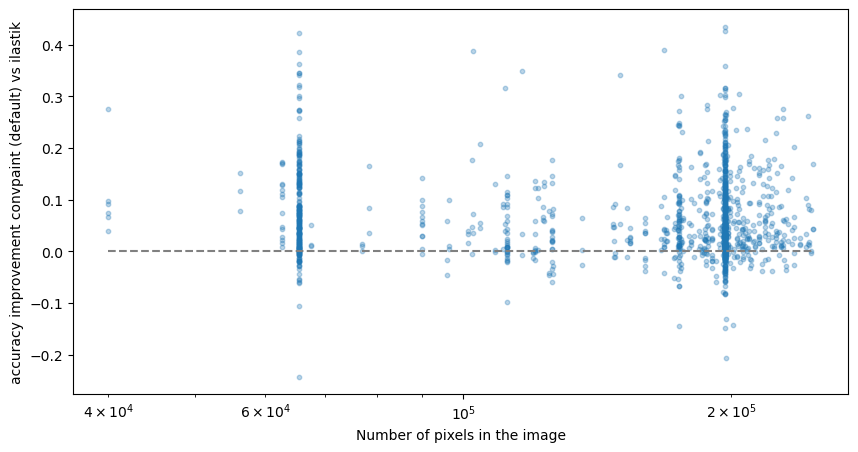

In [29]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df_filtered[(df['scribbles bin'] == 1)]

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.scatter(df_filtered["pix_in_img"], df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.3, s=10)
plt.xlabel("Number of pixels in the image")
plt.ylabel(f'{metric} improvement convpaint (default) vs ilastik')
plt.hlines(0, np.min(df_filtered["pix_in_img"]), np.max(df_filtered["pix_in_img"]), colors='grey', linestyles='dashed')
plt.xscale("log")
plt.show()

# Compare bins

### Improvement over Ilastik

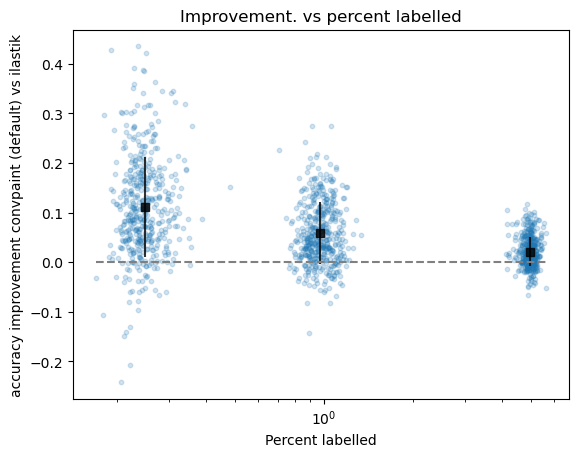

In [30]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df_filtered[(df_filtered['scribbles bin'] > 0.01) & (df_filtered['scribbles bin'] < 10)]
# bins_to_use = [0.1, 1, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

# Plot
plt.scatter(df_filtered['perc. labelled'], df_filtered[f'{metric}_impr_to_ilastik'], alpha=0.2, s=10)
df_grouped = df_filtered.groupby('scribbles bin').agg({f'{metric}_impr_to_ilastik': ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[f'{metric}_impr_to_ilastik']['mean'], yerr=df_grouped[f'{metric}_impr_to_ilastik']['std'], fmt='s', c='black', alpha=0.8)
plt.xscale('log')
plt.xlabel('Percent labelled')
plt.ylabel(f'{metric} improvement convpaint (default) vs ilastik')
plt.hlines(0, np.min(df_filtered['perc. labelled']), np.max(df_filtered['perc. labelled']), colors='grey', linestyles='dashed')
plt.title('Improvement. vs percent labelled')
plt.show()

### Performance of different models on separate dotplots side-by-side

In [31]:
def plot_perf_vs_perc_labelled(df, pred_to_show="convpaint", plt_ax=None, **kwargs):
    if plt_ax is None:
        plt_ax = plt.subplots(1, 1)[1]
    
    if pred_to_show:
        df_exact = df[df['prediction tag'] == pred_to_show]
        if len(df_exact) == 0:
            df_filtered = df[df['prediction tag'].str.contains(pred_to_show)]
        else:
            df_filtered = df_exact

    # Scatterplot
    plt_ax.scatter(df_filtered['perc. labelled'], df_filtered[metric], alpha=0.2, s=10, **kwargs)

    # Grouped plot
    df_grouped = df_filtered.groupby('scribbles bin').agg({metric: ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
    plt_ax.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['mean'], yerr=df_grouped[metric]['std'], fmt='s', c='black', alpha=0.8)
    plt_ax.set_xscale('log')
    plt_ax.set_ylim(0, 1)
    # plt_ax.set_xticks([0.05, 0.1, 1])
    plt_ax.set_xlabel('Percent labelled')
    plt_ax.set_ylabel(metric)
    plt_ax.set_title(f'{metric} vs percent labelled {pred_to_show}')

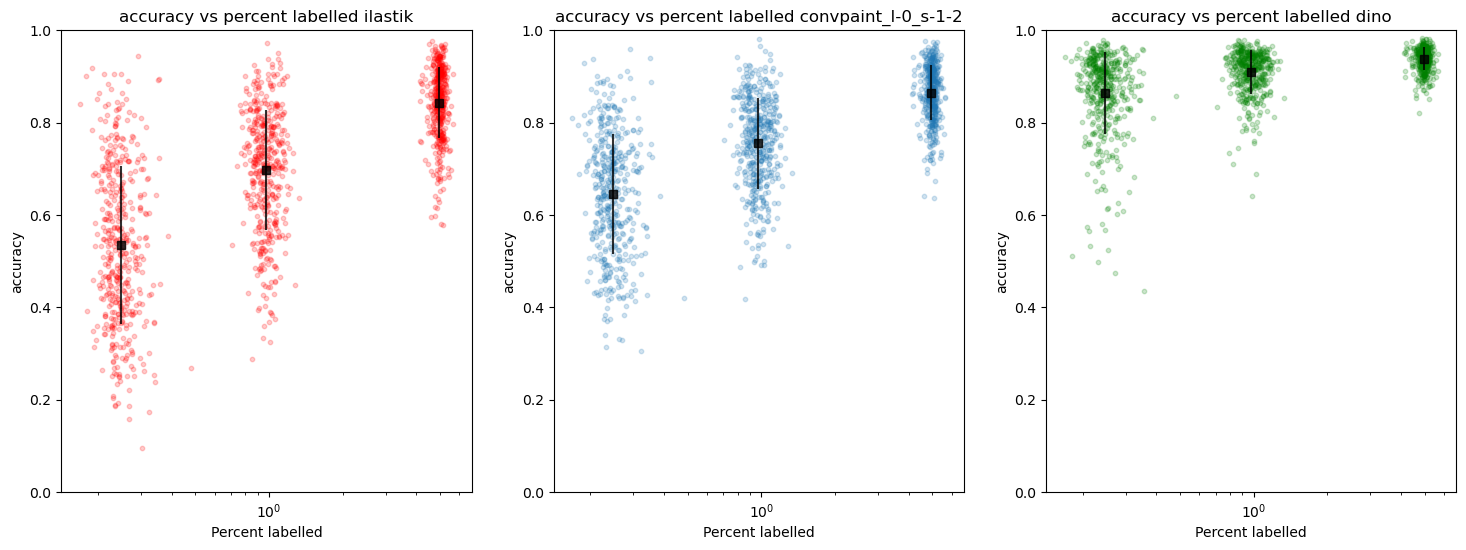

In [32]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df_filtered[(df_filtered['scribbles bin'] > 0.01) & (df_filtered['scribbles bin'] < 10)]
# bins_to_use = [0.1, 1, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

# Define the predictions to show
pred_tag_1 = 'ilastik'
pred_tag_2 = 'convpaint_l-0_s-1-2'
pred_tag_3 = 'dino'

# Plot
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
fig.set_dpi(100)
plot_perf_vs_perc_labelled(df, pred_tag_1, plt_ax=ax[0], c='red')
plot_perf_vs_perc_labelled(df, pred_tag_2, plt_ax=ax[1])
plot_perf_vs_perc_labelled(df, pred_tag_3, plt_ax=ax[2], c='green')
# plt.savefig(f'results/{metric}_vs_perc_labelled.pdf', dpi=300)
plt.show()

### Performance of different models on same dotplot

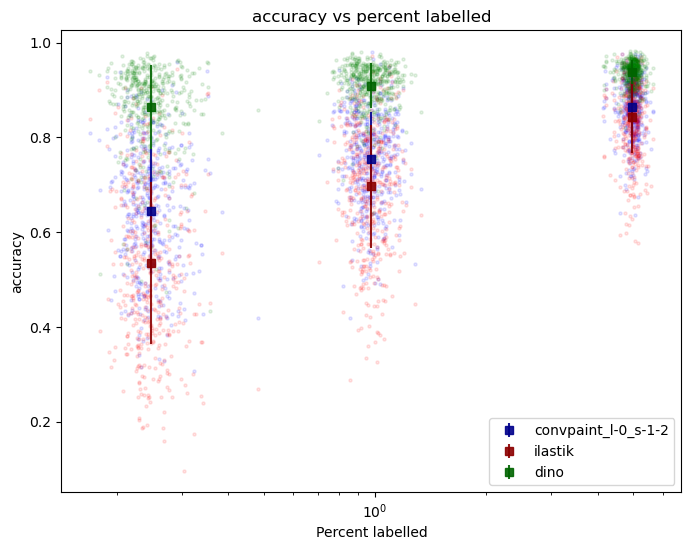

In [33]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
df_filtered = df[df['prediction tag'] == 'convpaint_l-0_s-1-2']
# df_filtered = df_filtered[(df_filtered['scribbles bin'] > 0.01) & (df_filtered['scribbles bin'] < 10)]
# bins_to_use = [0.1, 1, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

# # Define the predictions to show and created filtered dataframes
pred_tag_1 = 'convpaint_l-0_s-1-2'
pred_tag_2 = 'ilastik'
pred_tag_3 = 'dino'
df_filtered_1 = df[df['prediction tag'] == pred_tag_1]
df_filtered_2 = df[df['prediction tag'] == pred_tag_2]
df_filtered_3 = df[df['prediction tag'] == pred_tag_3]

# Plot performance vs percent labelled
plt.figure(figsize=(8,6),dpi=100)

# ADD FIRST PLOT
# Scatterplot
plt.scatter(df_filtered_1['perc. labelled'], df_filtered_1[metric], alpha=0.1, s=5, c='blue')
# Grouped plot
df_grouped = df_filtered_1.groupby('scribbles bin').agg({metric: ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['mean'], yerr=df_grouped[metric]['std'], fmt='s', c='darkblue', alpha=0.9, label=pred_tag_1)
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['median'], yerr=0, fmt='s', c='blue', alpha=0.9)

# ADD SECOND PLOT
# Scatterplot
plt.scatter(df_filtered_2['perc. labelled'], df_filtered_2[metric], alpha=0.1, s=5, c='red')
# Grouped plot
df_grouped = df_filtered_2.groupby('scribbles bin').agg({metric: ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['mean'], yerr=df_grouped[metric]['std'], fmt='s', c='darkred', alpha=0.9, label=pred_tag_2)
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['median'], yerr=0, fmt='s', c='red', alpha=0.9)

# ADD THIRD PLOT
# Scatterplot
plt.scatter(df_filtered_3['perc. labelled'], df_filtered_3[metric], alpha=0.1, s=5, c='green')
# Grouped plot
df_grouped = df_filtered_3.groupby('scribbles bin').agg({metric: ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['mean'], yerr=df_grouped[metric]['std'], fmt='s', c='darkgreen', alpha=0.9, label=pred_tag_3)
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped[metric]['median'], yerr=0, fmt='s', c='red', alpha=0.9)

# ADJUST PARAMETERS
plt.xscale('log')
plt.xlabel('Percent labelled')
plt.ylabel(metric)
plt.title(f'{metric} vs percent labelled')
plt.legend()
plt.show()

### VIOLINPLOT (performance vs. percent labelled)

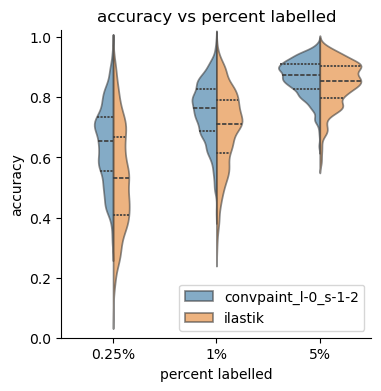

In [34]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
# df = df[(df['scribbles bin'] > 0.01) & (df['scribbles bin'] < 10)]
# bins_to_use = [0.1, 1, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

# Filter for the predicitons to use
pred_tag_1 = 'convpaint_l-0_s-1-2'
pred_tag_2 = 'ilastik'
df_filtered_1 = df[df['prediction tag'] == pred_tag_1]
df_filtered_2 = df[df['prediction tag'] == pred_tag_2]
df_both = pd.concat([df_filtered_1, df_filtered_2])

# Plot performance vs percent labelled (violin plot)
plt.figure(figsize=(4, 4), dpi=100)

# Create the violin plot
ax = sns.violinplot(x='scribbles bin', y=metric, data=df_both, hue='prediction tag', split=True, alpha=0.6, inner="quart", bw_adjust=0.65)

# Create line plot
# Group the bins
df_filtered_1_grouped = df_filtered_1.groupby('scribbles bin').agg({metric: 'median'}).reset_index()
df_filtered_2_grouped = df_filtered_2.groupby('scribbles bin').agg({metric: 'median'}).reset_index()
# Plot the means of each bin and connect them with a line
x_positions = ax.get_xticks()
# plt.plot(x_positions, df_filtered_1_grouped[metric], color='lightblue', alpha=0.8)
# plt.plot(x_positions, df_filtered_2_grouped[metric], color='orange', alpha=0.7)
# original colours: lightblue, orange

# Set some parameters
x_labels = [f"{int(x) if int(x)==x else x}%" for x in df_filtered_1_grouped['scribbles bin']]

plt.ylim(0, 1.025)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(x_positions, x_labels)
plt.legend(loc='lower right')
plt.xlabel('percent labelled')
plt.ylabel(metric)
plt.title(f'{metric} vs percent labelled')

# Show or save the plot
# plt.savefig("cellpose_results/cellpose_run04_convpaint-vs-ilastik_acc-vs-lab.pdf", format='pdf', dpi=300)
# plt.savefig("FoodSeg103_results/food_run04_convpaint-vs-ilastik_acc-vs-lab.pdf", format='pdf', dpi=300)
plt.show()


# Compare VGG16 layer/scaling combos

In [35]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter before comparing prediciton types (not for models, but e.g. for scribbles bins)
# df = df[(df['scribbles bin'] > 0.01) & (df['scribbles bin'] < 10)]
bins_to_use = [0.1, 1, 10]
df = df[df['scribbles bin'].isin(bins_to_use)]

# Split df for different bins
annot_bins = df['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df[df['scribbles bin'] == bin] for bin in annot_bins]

# For each model, create a list with dfs for each bin
bin_df_list_conv = [single_bin_df[single_bin_df['prediction tag'].str.contains('convpaint')] for single_bin_df in bin_df_list]
bin_df_list_ilastik = [single_bin_df[single_bin_df['prediction tag'].str.contains('ilastik')] for single_bin_df in bin_df_list]
bin_df_list_dino = [single_bin_df[single_bin_df['prediction tag'].str.contains('dino')] for single_bin_df in bin_df_list]

In [36]:
# Check if the lists are composed as intended
# bin_df_list_conv[-1][bin_df_list_conv[-1]['img_num'] == 0]
# bin_df_list_ilastik[0][bin_df_list_ilastik[0]['img_num'] < 2]
# bin_df_list_dino[0][bin_df_list_dino[0]['img_num'] < 2]

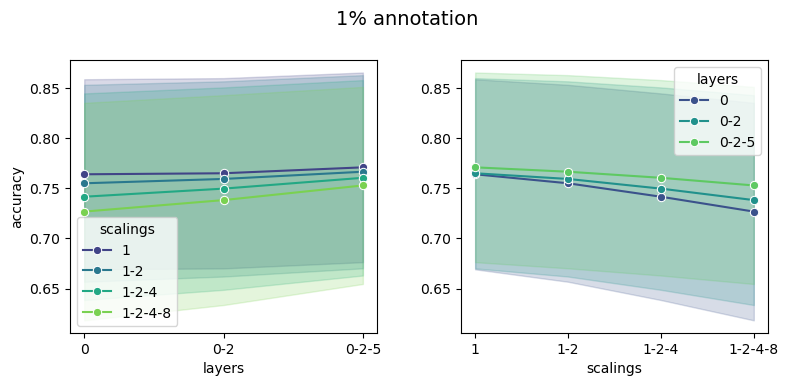

In [40]:
num_df = len(bin_df_list_conv)
fig, ax = plt.subplots(num_df, 2)
if ax is not np.ndarray:
    ax = np.array([ax])

fig.set_size_inches(8, 4 * num_df)
fig.set_dpi(100)

for i, df in enumerate(bin_df_list_conv):
    row = ax[i]
    sns.lineplot(x='layers', y=metric, data=df, hue='scalings', palette='viridis', errorbar='sd', marker='o',ax=row[0])
    sns.lineplot(x='scalings', y=metric, data=df, hue='layers', palette='viridis', errorbar='sd', marker='o',ax=row[1])
    # Hide y axis label of right plot
    row[0].set_title(f"{annot_bins[i]}% annotation", x=1.1, y=1.1, fontsize=14)
    row[1].set_ylabel('')
    # if i != num_df-1:
    #     row[0].set_xlabel('')
    #     row[1].set_xlabel('')
fig.tight_layout()
plt.show()

### Correlation between image resolution and effect of VGG16 scalings

In [41]:
scalings_to_comp = ['1-2-4-8', '1']
grouped_dfs = []
for df_conv_bin in bin_df_list_conv:
    # df_conv_bin = df_conv_bin[df_conv_bin['layers']=='0']
    # Group by 'img_num' and 'scalings' to compute average performance metric
    grouped_df = df_conv_bin.groupby(['img_num', 'scalings'])[metric].mean().unstack()
    grouped_df['img_num'] = grouped_df.index
    grouped_df['pix_in_img'] = df_conv_bin.groupby('img_num')['pix_in_img'].first().values
    grouped_df[f'{metric}_diff'] = grouped_df[scalings_to_comp[0]] - grouped_df[scalings_to_comp[1]]
    grouped_dfs.append(grouped_df)
# Display the result
grouped_dfs[0][:4]

scalings,1,1-2,1-2-4,1-2-4-8,img_num,pix_in_img,accuracy_diff
img_num,,,,,,,
0,0.859511,0.835860,0.805756,0.775430,0,196608,-0.084081
8,0.827439,0.833484,0.831583,0.809130,8,200704,-0.018309
24,0.636968,0.631107,0.649509,0.654253,24,196608,0.017285
32,0.826414,0.823920,0.828666,0.825090,32,196608,-0.001324


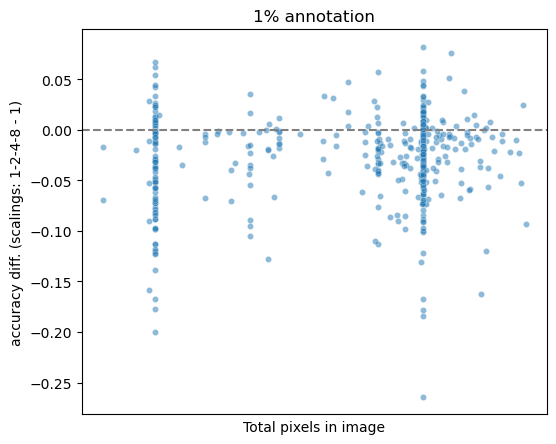

In [44]:
num_cols = int(np.ceil(num_df/2)) if num_df > 3 else num_df
num_rows = 2 if num_df > 3 else 1
fig, ax = plt.subplots(num_rows, num_cols)
if ax is not np.ndarray:
    ax = np.array([ax])
ax = ax.flatten()
fig.set_size_inches(6*num_cols, 5*num_rows)
fig.set_dpi(100)
for i, grouped_df in enumerate(grouped_dfs):
    curr_ax = ax[i]
    sns.scatterplot(x='pix_in_img', y=f'{metric}_diff', data=grouped_df, s=20, alpha=0.5, ax=curr_ax)
    # curr_ax.set_xscale('log')
    # curr_ax.set_yscale('log')
    curr_ax.axhline(0, color='grey', linestyle='--')
    curr_ax.set_xticks([])    
    curr_ax.set_xlabel('Total pixels in image')
    curr_ax.set_ylabel(f'{metric} diff. (scalings: {scalings_to_comp[0]} - {scalings_to_comp[1]})')
    curr_ax.set_title(f'{annot_bins[i]}% annotation')
plt.show()

# HEATMAPS for model comparison

### Different ConvPaint models (layers/scaling combinations)

In [45]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Take only convpaint predictions
df[df['prediction tag'].str.contains('convpaint')]

# Optionally filter before comparing prediciton types (e.g. for scribbles bins)
# df = df[(df['scribbles bin'] > 0.01) & (df['scribbles bin'] < 10)]
bins_to_use = [0.1, 1, 10]
df = df[df['scribbles bin'].isin(bins_to_use)]

# Split df for different bins
annot_bins = df['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df[df['scribbles bin'] == bin] for bin in annot_bins]
bin_df_list_conv = bin_df_list

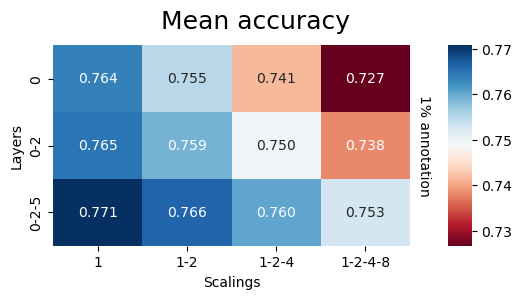

In [46]:
num_bins = len(annot_bins)
min_val = min([bin_df.pivot_table(index='layers', columns='scalings', values=metric).min().min() for bin_df in bin_df_list_conv])
max_val = max([bin_df.pivot_table(index='layers', columns='scalings', values=metric).max().max() for bin_df in bin_df_list_conv])
axis_matrix = [[str(bin), 'cbar'] for bin in annot_bins]
fig, ax = plt.subplot_mosaic(axis_matrix, gridspec_kw={'width_ratios': [15, 1]})
ax_list = [ax[str(bin)] for bin in annot_bins]

unit, dpi = 18, 100
ratio = unit / dpi
title_height = 4 * ratio
plot_height = title_height + (1 + 12 * num_bins) * ratio # title + bottom + plot per bin
plot_width = 18 * (30) / 100
fig.set_size_inches(plot_width, plot_height)
fig.set_dpi(100)
fig.suptitle(f'Mean {metric}', fontsize=18, y =  1 - 1/2*(title_height / plot_height))
fig.subplots_adjust(top = 1 - (title_height / plot_height))
# fig.tight_layout(rect=[0, 0, 1, 0.99])

for i, df in enumerate(bin_df_list_conv):
    row = ax_list[i]
    # Create a pivot table for heatmap
    heatmap_df_mean = df.pivot_table(index='layers', columns='scalings', values=metric)
    sns.heatmap(heatmap_df_mean, annot=True, cmap="RdBu", fmt=".3f", cbar=i==0, cbar_ax=ax['cbar'], ax=row, vmin=min_val, vmax=max_val)
    row.text(1.02, 0.5, f'{annot_bins[i]}% annotation', transform=row.transAxes, rotation=270, va='center')
    row.set_xlabel('Scalings' if i == num_bins - 1 else '')
    row.set_ylabel('Layers')

    # row.set_aspect('auto')

# plt.savefig(f'FoodSeg103_results/avg_{metric}_convpaint.pdf', dpi=300)
plt.show()

### Convpaint models vs. Ilastik and DINOv2

In [47]:
# Define which dataframe to use
# df = cellpose_df.copy()
# df = food_df.copy()
df = {"cellpose": cellpose_df.copy(), "food": food_df.copy()}[use_for_all]

# Optionally filter the dataframe
# df = df[(df['scribbles bin'] > 0.01) & (df['scribbles bin'] < 10)]
# bins_to_use = [0.1, 1, 10]
# df = df[df['scribbles bin'].isin(bins_to_use)]

# Split df for different bins
annot_bins = df['scribbles bin'].unique()
annot_bins = [int(bin) if int(bin) == bin else bin for bin in annot_bins]
bin_df_list = [df[df['scribbles bin'] == bin] for bin in annot_bins]

# For each model, create a list with dfs for each bin
bin_df_list_conv = [single_bin_df[single_bin_df['prediction tag'].str.contains('convpaint')] for single_bin_df in bin_df_list]
bin_df_list_ilastik = [single_bin_df[single_bin_df['prediction tag'].str.contains('ilastik')] for single_bin_df in bin_df_list]
bin_df_list_dino = [single_bin_df[single_bin_df['prediction tag'].str.contains('dino')] for single_bin_df in bin_df_list]

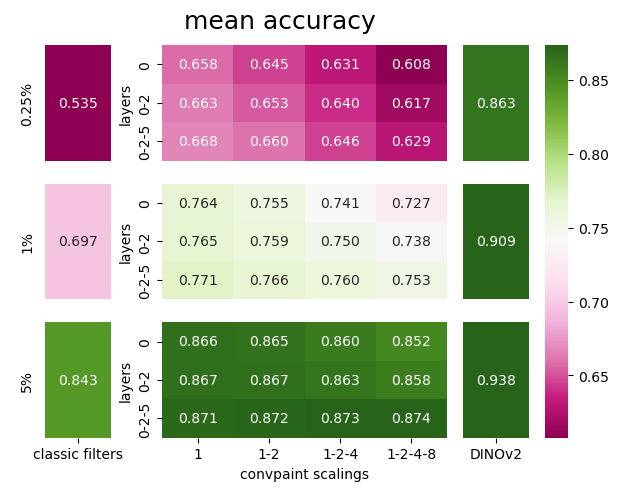

In [48]:
num_bins = len(annot_bins)
min_val = min([bin_df.pivot_table(index='layers', columns='scalings', values=metric).min().min() for bin_df in bin_df_list_conv])
max_val = max([bin_df.pivot_table(index='layers', columns='scalings', values=metric).max().max() for bin_df in bin_df_list_conv])

axis_matrix = np.array([['pad left', 
                          str(bin)+'ilastik', 
                          'pad', 
                          str(bin)+'convpaint', 
                          str(bin)+'dino', 
                          'cbar'] for bin in annot_bins])
fig, ax = plt.subplot_mosaic(axis_matrix, gridspec_kw={'width_ratios': [1, 3.5, 1, 15, 3.5, 1.2]})
for pad in ['pad left', 'pad']: ax[pad].axis('off')

unit, dpi = 18, 100
ratio = unit / dpi
title_height = 4 * ratio
plot_height = title_height + (1 + 8 * num_bins) * ratio # title + bottom + plot per bin
plot_width = unit * (40) / 100
fig.set_size_inches(plot_width, plot_height)
fig.set_dpi(100)
fig.suptitle(f'mean {metric}', fontsize=unit, y =  1 - 1/2*(title_height / plot_height))
fig.subplots_adjust(top = 1 - (title_height / plot_height))
# fig.tight_layout(rect=[0, 0, 1, 0.99])

heatmap_cfg = {"annot":True, "cmap":"PiYG", "fmt":".3f", "cbar_ax":ax['cbar'], "vmin":min_val, "vmax":max_val}
# original cmap = 'YlGnBu'; good alternatives: twilight_shifted, RdBu, PuBuGn, PuBu, BuGn, PiYG

# CONVPAINT
ax_list_conv = [ax[ax_idx] for ax_idx in axis_matrix[:,3]]#[ax['upper left'], ax['mid left'], ax['lower left']]
for i, df in enumerate(bin_df_list_conv):
    row = ax_list_conv[i]
    # Create a pivot table for heatmap
    heatmap_df_mean = df.pivot_table(index='layers', columns='scalings', values=metric)
    sns.heatmap(heatmap_df_mean, cbar=i==0, ax=row, **heatmap_cfg)

    row.set_xlabel('convpaint scalings' if i == num_bins - 1 else '')
    if not i == num_bins - 1: row.set_xticks([])
    row.set_ylabel('layers')

# ILASTIK
ax_list_ila = [ax[ax_idx] for ax_idx in axis_matrix[:,1]] #[ax['upper mid'], ax['mid mid'], ax['lower mid']]
for i, df in enumerate(bin_df_list_ilastik):
    row = ax_list_ila[i]
    # Create a pivot table for heatmap, but only use the one value given for Ilastik
    heatmap_df_mean = df[metric].mean().reshape((1,1))
    sns.heatmap(heatmap_df_mean, cbar=False, ax=row, **heatmap_cfg)

    if i == num_bins - 1:
        row.set_xticklabels(["classic filters"])
    else:
        row.set_xticks([])
    row.set_yticks([])
    row.text(-0.37, 0.5, f'{annot_bins[i]}%', transform=row.transAxes, rotation=90, va='center')

# DINOv2
ax_list_dino = [ax[ax_idx] for ax_idx in axis_matrix[:,4]]
for i, df in enumerate(bin_df_list_dino):
    row = ax_list_dino[i]
    # Create a pivot table for heatmap, but only use the one value given for Ilastik
    heatmap_df_mean = df[metric].mean().reshape((1,1))
    sns.heatmap(heatmap_df_mean, cbar=False, ax=row, **heatmap_cfg)

    if i == num_bins - 1:
        row.set_xticklabels(["DINOv2"])
    else:
        row.set_xticks([])
    row.set_yticks([])

# plt.savefig(f'cellpose_results/cellpose_run04_avg_{metric}_heatmap.pdf', dpi=300)
# plt.savefig(f'FoodSeg103_results/food_run04_avg_{metric}_heatmap.pdf', dpi=300)
plt.show()